<h1> Proiect ACI </h1>

In [1]:
import os
import cv2

import numpy as np
import glob
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

In [2]:
tumour_images=[]
for name in glob.glob('brain_tumor_dataset/yes/*.jpg'): 
    image = cv2.imread(name)
    image = cv2.resize(image,(240,240))
    tumour_images.append(image)

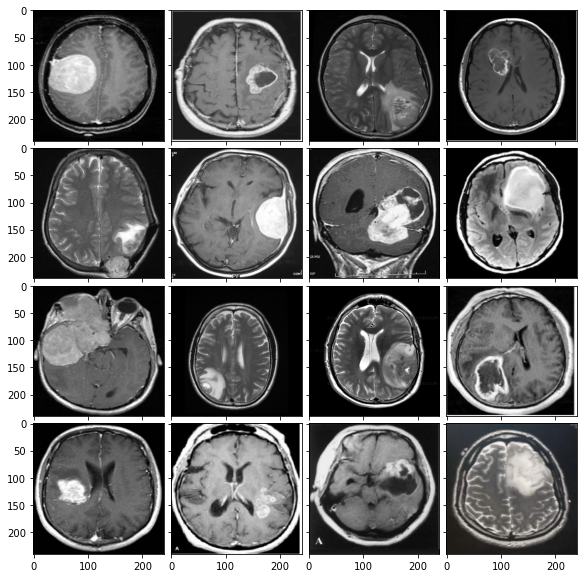

In [3]:
fig = plt.figure(figsize=(10., 10.))
grid = ImageGrid(fig, 111, nrows_ncols=(4, 4),  axes_pad=0.1,   )
for ax, im in zip(grid, tumour_images[0:16]):
    ax.imshow(im)
plt.show()

<h1> Step by Step on 1 image </h1>

width: 300 pixels
height: 347 pixels
channels: 3


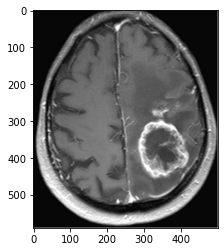

In [655]:
img_path = "brain_tumor_dataset/yes/Y183.jpg" #104 #3


image = cv2.imread(img_path)
print("width: {} pixels".format(image.shape[1]))
print("height: {} pixels".format(image.shape[0]))
print("channels: {}".format(image.shape[2]))
dim=(500,590)
image=cv2.resize(image, dim)
plt.imshow(image)

In [656]:
total_mri = 150

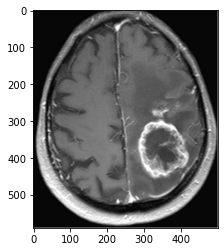

In [657]:
plt.imshow(image)

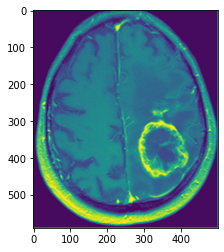

In [658]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY, 0.7)
plt.imshow(gray)

In [659]:
print(np.mean(gray))
print(round(np.average(gray, axis = (0,1))))

85.40364745762712
85


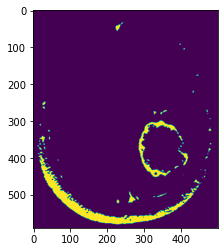

In [669]:
(T, thresh) = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY) #155 #110
plt.imshow(thresh)

In [670]:
#(T, threshInv) = cv2.threshold(gray, 155, 255, cv2.THRESH_BINARY_INV)
#plt.imshow(threshInv)

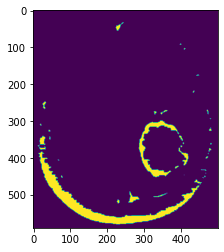

In [675]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 5))#2d convolution with kernel
closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel) #close any small noise points in highlighted areas
plt.imshow(closed)


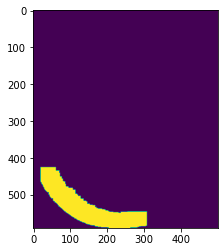

In [676]:
closed = cv2.erode(closed, None, iterations =8) #remove noise
closed = cv2.dilate(closed, None, iterations = 19) #increase wanted area
plt.imshow(closed)

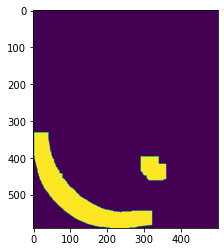

In [664]:
plt.imshow(closed) #13-17

In [79]:
def auto_canny(image, sigma=0.33):
    # compute the median of the single channel pixel intensities
    v = np.median(image)
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)
    # return the edged image
    return edged

#canny = auto_canny(closed)
#plt.imshow(canny)

def do_sobel(img):
    scale = 1
    delta = 0
    ddepth = cv2.CV_16S

    img = cv2.GaussianBlur(img, (3, 3), 0)
    grad_x = cv2.Sobel(img, ddepth, 1, 0, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
    grad_y = cv2.Sobel(img, ddepth, 0, 1, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
    abs_grad_x = cv2.convertScaleAbs(grad_x)
    abs_grad_y = cv2.convertScaleAbs(grad_y) 
    
    grad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)
    return grad

#sobel = do_sobel(closed)
#plt.imshow(sobel)

In [80]:
(cnts, _) = cv2.findContours(sobel.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(image, cnts, -1, (255, 0, 0), 2)
plt.imshow(image) 

NameError: name 'sobel' is not defined

In [81]:
def save_image(name, img):
    path = 'Canny_results'
    first_split = name.split("\\")
    second_split = first_split[1].split(".")
    id = second_split[0]
    new_name = "Canny_" + id
    save_name = os.path.join(path , new_name) + ".png"
    cv2.imwrite(save_name, img);
    
def save_image_sobel(name, img):
    path = 'Sobel_results'
    first_split = name.split("\\")
    second_split = first_split[1].split(".")
    id = second_split[0]
    new_name = "Sobel_" + id
    save_name = os.path.join(path , new_name) + ".png"
    cv2.imwrite(save_name, img);

In [677]:
canny_images = []
sobel_images = []
    
def detect_canny():
    global canny_images
    count = 0
    for name in glob.glob('brain_tumor_dataset/yes/*.jpg'): 
        image = cv2.imread(name)
        count = count + 1
        dim=(500,590)
        image=cv2.resize(image, dim)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY, 0.7) #greyscale conversion for threshholding
        value = round(np.mean(image))
        print(name, value)
        if value <= 50:
            #
            (T, thresh) = cv2.threshold(gray, value+120, 255, cv2.THRESH_BINARY)
        elif value >= 100:
            (T, thresh) = cv2.threshold(gray, value+70, 255, cv2.THRESH_BINARY)
        else:
            (T, thresh) = cv2.threshold(gray, value+70, 255, cv2.THRESH_BINARY) #threshholding pixels
        
        #details above
        
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 5))
        closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
        
        if value > 50 and value <= 84:
            closed = cv2.erode(closed, None, iterations = 10)
            closed = cv2.dilate(closed, None, iterations = 19)
        elif value <= 50:
            #print(name, value)
            closed = cv2.erode(closed, None, iterations = 7)
            closed = cv2.dilate(closed, None, iterations = 17)
        elif value >= 100:
            closed = cv2.erode(closed, None, iterations = 16)
            closed = cv2.dilate(closed, None, iterations = 17)
        else:
            closed = cv2.erode(closed, None, iterations = 19)
            closed = cv2.dilate(closed, None, iterations = 17)

        
        #do canny
        canny = auto_canny(closed)
        
        #find contours of selected area
        (cnts, _) = cv2.findContours(canny.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        #overlap contour on original image
        cv2.drawContours(image, cnts, -1, (0, 0, 255), 2)
        canny_images.append(image)
        save_image(name,image)
    print (count)
        
def detect_sobel():
    global sobel_images
    for name in glob.glob('brain_tumor_dataset/yes/*.jpg'): 
        image = cv2.imread(name)
        
        dim=(500,590)
        image=cv2.resize(image, dim)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY, 0.7) #greyscale conversion for threshholding
        
        (T, thresh) = cv2.threshold(gray, 155, 255, cv2.THRESH_BINARY) #threshholding #thresholding pixels
        
        #details above
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 5))
        closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
        closed = cv2.erode(closed, None, iterations = 17)
        closed = cv2.dilate(closed, None, iterations = 1)

        
        #do canny
        sobel = do_sobel(closed)
        
        #find contours of selected area
        (cnts, _) = cv2.findContours(sobel.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        #overlap contour on original image
        cv2.drawContours(image, cnts, -1, (0, 0, 255), 2)
        sobel_images.append(image)
        save_image_sobel(name,image)        

In [678]:
detect_canny()

brain_tumor_dataset/yes\Y1.jpg 76
brain_tumor_dataset/yes\Y10.jpg 110
brain_tumor_dataset/yes\Y100.JPG 52
brain_tumor_dataset/yes\Y101.jpg 51
brain_tumor_dataset/yes\Y102.jpg 75
brain_tumor_dataset/yes\Y103.jpg 108
brain_tumor_dataset/yes\Y104.jpg 94
brain_tumor_dataset/yes\Y105.jpg 87
brain_tumor_dataset/yes\Y106.jpg 85
brain_tumor_dataset/yes\Y107.jpg 46
brain_tumor_dataset/yes\Y108.jpg 57
brain_tumor_dataset/yes\Y109.JPG 110
brain_tumor_dataset/yes\Y11.jpg 81
brain_tumor_dataset/yes\Y111.JPG 131
brain_tumor_dataset/yes\Y112.JPG 93
brain_tumor_dataset/yes\Y113.JPG 93
brain_tumor_dataset/yes\Y114.JPG 48
brain_tumor_dataset/yes\Y115.JPG 73
brain_tumor_dataset/yes\Y116.JPG 72
brain_tumor_dataset/yes\Y117.JPG 76
brain_tumor_dataset/yes\Y12.jpg 95
brain_tumor_dataset/yes\Y120.JPG 71
brain_tumor_dataset/yes\Y13.jpg 106
brain_tumor_dataset/yes\Y14.jpg 108
brain_tumor_dataset/yes\Y146.JPG 96
brain_tumor_dataset/yes\Y148.JPG 106
brain_tumor_dataset/yes\Y15.jpg 92
brain_tumor_dataset/yes\Y153.

In [248]:
#detect_sobel()

In [679]:
def check_red(image):
    h, w = image.shape[:2]
    for i in range(h):
        for j in range(w):
            b,g,r = image[i, j]
            if b == 0 and g == 0 and r == 255:
                return True
    return False

def percentage(part, whole):
    Percentage = 100 * float(part)/float(whole)
    return str(Percentage) + "%"

In [680]:
def check_canny():
    global total_mri
    print(total_mri)
    counter = 0
    #for name in glob.glob('brain_tumor_dataset/yes/*.jpg'): 
    for name in glob.glob('Canny_results/*.png'):
        #print("yes")
        image = cv2.imread(name)
        isRed = check_red(image)
        if isRed is True:
            counter += 1
    print (percentage(counter, total_mri))
    
check_canny()

150
84.66666666666667%


In [19]:
def check_sobel():
    counter = 0
    for name in glob.glob('Canny_results/*.png'): 
        image = cv2.imread(name)
        isRed = check_red(image)
        if isRed is True:
            counter += 1
    print (percentage(counter, 154))
    
check_sobel()

59.74025974025974%


In [ ]:
#59.74025974025974%
#75.97402597402598% 60
#71.42857142857143% 66
#73.37662337662337% 63
#77.92207792207792% 55
#83.11688311688312% 50
#68.18181818181819% 75
#78.0%
#84.66666666666667%
#84.66666666666667%